In [23]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications import DenseNet121
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization
from pathlib import Path
import glob
import math
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:4]:
        print(os.path.join(dirname, filename))

/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b1_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b4_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/.travis.yml
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/.gitignore
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/requirements.txt
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/MANIFEST.in
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/misc/labels_map.txt
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/misc/panda.jpg
/kaggle/input/efficientnet-keras-source-code/repository/qubvel-effici

In [3]:
!pip install -U efficientnet

  Found existing installation: efficientnet 0.0.4
    Uninstalling efficientnet-0.0.4:
      Successfully uninstalled efficientnet-0.0.4


In [1]:
!pip install ../input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/ --quiet

In [12]:
from efficientnet import EfficientNetB5

In [30]:
CLASSS={0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}
SEED=7
df_train=pd.read_csv("../input/aptos2019-blindness-detection/train.csv") 
df_test=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
x_train,x_test,y_train,y_test=train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2, random_state =SEED, stratify=df_train.diagnosis)
IMG_DIM=256 #512
size=256,256
BATCH_SIZE = 1
CHANNEL_SIZE=3
NUM_EPOCHS=12
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()


In [13]:
path = "../input/aptos2019-blindness-detection/train_images/"

In [28]:
def load_image(path):
    img = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), size)
    img = get_cropped_image(img)
    return img
def get_cropped_image(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    return cropped_img
def random_crop(img):
    # Note: image_data_format is 'channel_last'
    img = cv2.blur(img,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    return cropped_img


[[[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 3]
  [0 1 3]
  [0 1 3]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 3]
  [0 1 3]
  [0 1 3]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...


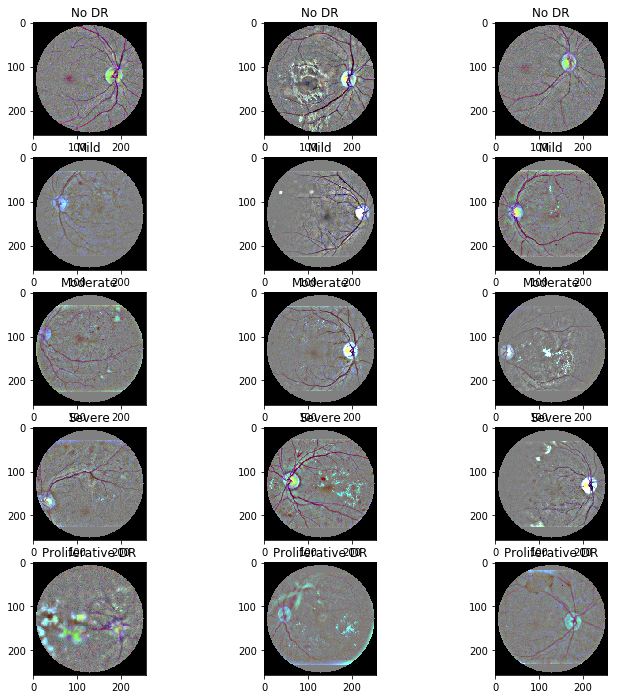

In [17]:
figure=plt.figure(figsize=(20,12))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(3, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        res_image = resize_image(img)
        sub_med = subtract_median_bg_image(res_image)
        img_rad_red=Radius_Reduction(sub_med, PARAM)
        plt.imshow(img_rad_red)
        ax.set_title(CLASSS[target_class])

In [ ]:
root = '/kaggle/input/aptos2019-blindness-detection/'

In [31]:
from keras.preprocessing.image import ImageDataGenerator
NUM_CLASSES = df_train['diagnosis'].nunique()
x_train,x_test,y_train,y_test=train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2, random_state =SEED, stratify=df_train.diagnosis)
CLASSS={0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}
df_train.id_code=df_train.id_code.apply(lambda x: x+".png")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True,preprocessing_function=random_crop)
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="../input/aptos2019-blindness-detection/train_images",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='training', 
                                
                                                  seed=SEED,
                                                 )
valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="../input/aptos2019-blindness-detection/train_images",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='validation',
                                                  
                                                  seed=SEED
                                                 )

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [ ]:
del x_train 
# # del x_test
del y_train
# del y_test
gc.collect()

In [19]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr  = ReduceLROnPlateau(monitor='val_loss',  min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6,  mode='auto', verbose=1)

In [20]:
NUB_TRAIN_STEPS=train_generator.n//train_generator.batch_size
NUB_VALID_STEPS=valid_generator.n//valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(2930, 732)

In [ ]:
os.listdir("../input/densenet-keras")

In [35]:
eff_net = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

115302400/115295288 [==============================] - 1s 0us/step


In [41]:
os.listdir('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

['efficientnet-b1_imagenet_1000_notop.h5',
 'efficientnet-b5_imagenet_1000_notop.h5',
 'efficientnet-b4_imagenet_1000_notop.h5',
 'efficientnet-b3_imagenet_1000_notop.h5',
 'efficientnet-b0_imagenet_1000_notop.h5',
 'efficientnet-b2_imagenet_1000_notop.h5']

In [42]:
def create_resnet(img_dim,CHANNEL,n_class):
    input_tensor=Input(shape=(img_dim, img_dim,CHANNEL))
  
    base_model = EfficientNetB5(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')
    
    x=GlobalAveragePooling2D()(base_model.output)
    x=Dropout(0.3)(x)
    x=Dense(1024, activation=relu)(x)
    x=Dropout(0.2)(x)
    x=Dense(512, activation=relu)(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    output_layer=Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_resnet =Model(input_tensor, output_layer)
    
    return model_resnet
model_resnet=create_resnet(IMG_DIM,CHANNEL_SIZE, NUM_CLASSES)

In [43]:
for layers in model_resnet.layers:
    layers.trainable=True

In [44]:
lr = 1e-3
optimizer=rmsprop(lr=lr,decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model.summary()
gc.collect()

1267

In [45]:
history=model_resnet.fit_generator(generator=train_generator,
                           steps_per_epoch=NUB_TRAIN_STEPS,
                           validation_data=valid_generator,
                           validation_steps=NUB_VALID_STEPS,
                           epochs=NUM_EPOCHS,
#                            shuffle=True,  
                           callbacks=[eraly_stop, reduce_lr],
                           verbose=2)

Epoch 1/12


KeyboardInterrupt: 

In [ ]:
accu=history.history['acc']
val_acc=history.history['val_acc']

plt.plot(accu,label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc','val_acc'])
plt.plot( np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r", label="best model")
plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
(eval_loss, eval_accuracy)=tqdm(model.evaluate_generator(generator=valid_generator,steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss))

In [ ]:
test_datagen=image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True,preprocessing_function=preprocess_image)

test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory = "../input/aptos2019-blindness-detection/test_images/",
                                                x_col="id_code",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                batch_size=1,
                                                shuffle=False, 
                                                class_mode=None, 
                                                seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

In [ ]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model.predict_generator(generator=test_generator,steps =ceil(df_test.shape[0]))
#     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))

In [ ]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

In [ ]:
results=pd.DataFrame({"id_code":test_generator.filenames, "diagnosis":predicted_class_indices})  
results.id_code=results.id_code.apply(lambda x: x[:-4])# results.head()
results.to_csv("submission.csv", index=False)